# Getting started with Task 3

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) using the script `download_intracardiac_dataset.sh`:

```bash
source download_intracardiac_dataset.sh
```

## Load Modules and Preprocessing Functions

Load modules and preprocessing functions.

In [1]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_path = '/content/drive/MyDrive/cardiac_challenge_team6'
local_path = '../'

Load the `cardiac_ml_tools` module.

In [4]:
%run $drive_path/notebooks/cardiac_ml_tools.py

## Load the dataset

## Dataset details

The dataset [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106)
consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals.
In total, 16140 organ-level simulations were conducted to create this dataset.
Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores.
Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals.
For convenience, we collect those signals in matrices and give them the following names:

Tensor | Description | Shape | Notes
--- | --- | --- | ---
$X$ | Row electrode signals | $10 \times 500$ | 10-lead ECG signals from the simulated torso (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$V$ | Activation map | $75 \times 500$ | Transmembrane voltage signals from the simulated heart (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$E$ | 12-lead ECG signals | $12 \times 500$ | 12-lead ECG signals obtained by `get_standard_leads`($X$)
$A$ | Activation map | $75 \times 1$ | Activation time, defined as $A_i = \text{min}_j(V_{ij})$

**IMPORTANT** : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function `get_standard_leads` (in the file `cardiac_ml_tools.py`).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

![ECG 10 2 12](../figures/data_generation.png)

## Getting the standard 12-lead ECG from the 10-lead ECG

The function `get_standard_leads` (in the file `cardiac_ml_tools.py`) is used to obtain the 12-lead ECG signals from the 10-lead ECG signals. It implements the following transformation, where the (Wilson Lead) is defined as $Vw = 1/3*(RA + LA + LL)$:
$$
\left\{
\begin{array}{lll}
    X_{:,1}  & \to  & RA \\
    X_{:,2}  & \to  & LA \\
    X_{:,3}  & \to  & LL \\
    X_{:,4}  & \to  & RL \\
    X_{:,5}  & \to  & V1 \\
    X_{:,6}  & \to  & V2 \\
    X_{:,7}  & \to  & V3 \\
    X_{:,8}  & \to  & V4 \\
    X_{:,9}  & \to  & V5 \\
    X_{:,10} & \to &  V6 \\
\end{array}
\right.
\text{        and        }
\left\{
\begin{array}{lll}          
\text{Lead } I& : & LA - RA \\
\text{Lead } II& : & LL - RA \\
\text{Lead } III& : & LL - LA \\
\text{Lead } aVR& : &  \frac{3}{2} (RA - Vw) \\
\text{Lead } aVL& : &  \frac{3}{2} (LA - Vw) \\
\text{Lead } aVF& : &  \frac{3}{2} (LL - Vw)\\
\text{Lead } V1 & : & V1 - Vw \\
\text{Lead } V2 & : & V2 - Vw \\
\text{Lead } V3 & : & V3 - Vw \\
\text{Lead } V4 & : & V4 - Vw \\
\text{Lead } V5 & : & V5 - Vw \\
\text{Lead } V6 & : & V6 - Vw \\
\end{array}
\right.
$$

In [ ]:
# load data from files into numpy arrays

ECG_Data = np.load('../Task_3_4_Data/ECG_Data.npy')
ActTimes = np.load('../Task_3_4_Data/Activation_Times.npy')
VMData = np.load('../Task_3_4_Data/VmData.npy')

print(ActTimes.shape)

(16117, 75, 1)


In [ ]:
# grabbing data into tensors
ecg_tensor = torch.from_numpy(ECG_Data).type(torch.float)
vm_tensor = torch.from_numpy(VMData).type(torch.float)
print(ecg_tensor.shape, '\n', vm_tensor.shape)

In [ ]:
''' NORMALIZATION part 1

ECG Data (500x12) is scaled by:
ecg / ( max(ecg) - min(ecg) )
where min max is from each individual lead in each individual heart sample (smaller scope)
so min max will be from 500x1 for each of 12 leads in each of 16117 hearts
'''

def ecg_norm(ecg_data):
  X_norm = torch.zeros((ecg_tensor.shape[0], ecg_tensor.shape[1], ecg_tensor.shape[2]))
  max_ecgs = np.amax(ecg_data, axis=1)
  min_ecgs = np.amin(ecg_data, axis=1)
  for i, heart in enumerate(ecg_data): # iter through each data sample
    for j, leads in enumerate(heart): # iter through lead values at t = j
      max_ecgs_per_heart = max_ecgs[i]
      min_ecgs_per_heart = min_ecgs[i]
      for k, ecg in enumerate(leads): # apply scaler to each value in lead vectors
        max_ecg = max_ecgs_per_heart[k]
        min_ecg = min_ecgs_per_heart[k]
        X_norm[i][j][k] = ecg / (max_ecg - min_ecg)

    if i%100 == 0: # plot every 100th heart for verification
      plt.figure(1)
      #x_time = np.arange(0,500, 1)
      #unnorm = ecg_data.reshape(ecg_data.shape[0], ecg_data.shape[2],ecg_data.shape[1])
      #print("RESHAPE***",unnorm.shape)
      plt.plot(ecg_data[i],marker='.')
      plt.figure(2)
      #norm = X_norm.reshape(X_norm.shape[0], X_norm.shape[2], X_norm.shape[1])
      plt.plot(X_norm[i],marker='.')


  plt.show()

  return X_norm


ecg_data_norm = ecg_norm(ECG_Data)

In [ ]:
''' NORMALIZATION part 2

VM Data (500x75) scaled by:
( vm - min(D) ) / ( max(D) - min(D) )
where min max is is from each cardioid point across ALL hearts in dataset (larger scope)
so min max will be from 16117x500 for each of 75 points
'''

def vm_norm(vm_data):
  Y_norm = torch.zeros((vm_tensor.shape[0], vm_tensor.shape[1], vm_tensor.shape[2]))

  vm_mins = np.amin(vm_data, axis=(0,1)) # min/max across the whole data set for each cardioid point
  vm_maxs = np.amax(vm_data, axis=(0,1))

  for i, heart in enumerate(vm_data): # now iterate through set and apply norm formula to all points
    for j, mapping in enumerate(heart):
      for k, voltage in enumerate(mapping):
        temp_max = vm_maxs[k]
        temp_min = vm_mins[k]
        Y_norm[i][j][k] = ( voltage - temp_min ) / ( temp_max - temp_min )

  plt.figure(1)
  plt.plot(vm_data[0],marker='.')
  plt.figure(2)

  plt.plot(Y_norm[0],marker='.')
  plt.show()

  return Y_norm

vm_data_norm = vm_norm(VMData)

In [ ]:
# convert VMData into activation times
ActTimes = np.zeros((VMData.shape[0], 75, 1))
for i, heart in enumerate(VMData):
    heart_act = get_activation_time(heart)
    ActTimes[i] = heart_act

print(ActTimes.shape, ActTimes.size, ActTimes[0])

(16117, 75, 1) 1208775 [[ 9.]
 [ 5.]
 [ 2.]
 [ 7.]
 [ 3.]
 [ 1.]
 [ 8.]
 [ 5.]
 [ 2.]
 [ 8.]
 [ 8.]
 [ 4.]
 [ 7.]
 [ 1.]
 [12.]
 [12.]
 [ 2.]
 [ 5.]
 [ 8.]
 [11.]
 [ 7.]
 [ 3.]
 [ 8.]
 [ 5.]
 [ 1.]
 [ 9.]
 [ 5.]
 [ 2.]
 [ 4.]
 [ 9.]
 [ 5.]
 [ 4.]
 [11.]
 [ 4.]
 [11.]
 [ 6.]
 [ 2.]
 [ 3.]
 [ 9.]
 [13.]
 [12.]
 [ 8.]
 [ 2.]
 [11.]
 [ 7.]
 [11.]
 [ 7.]
 [ 2.]
 [ 2.]
 [15.]
 [10.]
 [ 3.]
 [ 5.]
 [ 1.]
 [ 4.]
 [ 8.]
 [ 2.]
 [ 4.]
 [10.]
 [ 4.]
 [ 8.]
 [ 2.]
 [ 5.]
 [ 2.]
 [ 5.]
 [ 8.]
 [ 4.]
 [10.]
 [ 4.]
 [11.]
 [ 7.]
 [ 3.]
 [ 3.]
 [ 8.]
 [13.]]


0.0 185.0
(16117, 75, 1) [[0.04864865]
 [0.02702703]
 [0.01081081]
 [0.03783784]
 [0.01621622]
 [0.00540541]
 [0.04324324]
 [0.02702703]
 [0.01081081]
 [0.04324324]
 [0.04324324]
 [0.02162162]
 [0.03783784]
 [0.00540541]
 [0.06486486]
 [0.06486486]
 [0.01081081]
 [0.02702703]
 [0.04324324]
 [0.05945946]
 [0.03783784]
 [0.01621622]
 [0.04324324]
 [0.02702703]
 [0.00540541]
 [0.04864865]
 [0.02702703]
 [0.01081081]
 [0.02162162]
 [0.04864865]
 [0.02702703]
 [0.02162162]
 [0.05945946]
 [0.02162162]
 [0.05945946]
 [0.03243243]
 [0.01081081]
 [0.01621622]
 [0.04864865]
 [0.07027027]
 [0.06486486]
 [0.04324324]
 [0.01081081]
 [0.05945946]
 [0.03783784]
 [0.05945946]
 [0.03783784]
 [0.01081081]
 [0.01081081]
 [0.08108108]
 [0.05405405]
 [0.01621622]
 [0.02702703]
 [0.00540541]
 [0.02162162]
 [0.04324324]
 [0.01081081]
 [0.02162162]
 [0.05405405]
 [0.02162162]
 [0.04324324]
 [0.01081081]
 [0.02702703]
 [0.01081081]
 [0.02702703]
 [0.04324324]
 [0.02162162]
 [0.05405405]
 [0.02162162]
 [0.05945

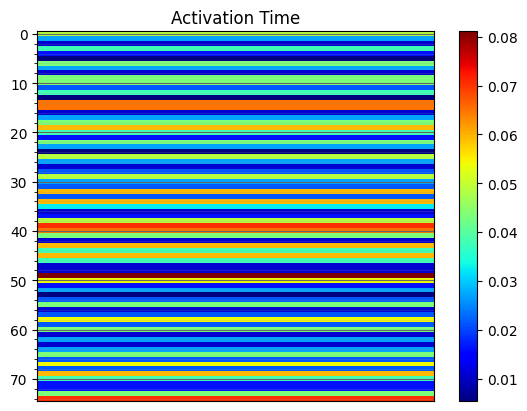

In [ ]:
''' NORMALIZATION part 3

Activation Times Data is simple min max scaler
where min and max are across whole data set
'''

def act_norm(act_times):
    act_norm = np.zeros((act_times.shape[0], 75, 1))
    min_act_time = np.amin(act_times, axis=(0,1))[0]
    max_act_time = np.amax(act_times, axis=(0,1))[0]
    print(min_act_time, max_act_time)
    for i, heart in enumerate(act_times):
        for j, time in enumerate(heart):
            scaled = ( time[0] - min_act_time ) / ( max_act_time - min_act_time )
            act_norm[i][j][0] = scaled
    print(act_norm.shape, act_norm[0])
    return act_norm

act_data_norm = act_norm(ActTimes)
print(act_data_norm[0])

# plot the Activation Time array
plt.imshow(act_data_norm[0], cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Activation Time')
plt.colorbar()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
# not xticks
plt.xticks([])
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

In [16]:
def write_norm_data(fn, data):
    np.save(f"{drive_path}/Task_3_4_Data_norm/{fn}.npy", data)

# verify normalization worked checking for all non zero elements
#print(ecg_data_norm.size, vm_data_norm.size, act_data_norm.size)
#print(ECG_Data.size, VMData.size)
#write_norm_data('Activation_Times_NORM', act_data_norm)
#write_norm_data('ECG_Data_NORM', ecg_data_norm)
#write_norm_data('VmData_NORM', vm_data_norm)

In [5]:
# load norm data
ecg_data_norm = np.load(f'{drive_path}/Task_3_4_Data_norm/ECG_Data_NORM.npy')
vm_data_norm = np.load(f'{drive_path}/Task_3_4_Data_norm/VmData_NORM.npy')
act_data_norm = np.load(f'{drive_path}/Task_3_4_Data_norm/Activation_Times_NORM.npy')

In [12]:
''' Transposing Data '''
data_len = ecg_data_norm.shape[0]

ecg_norm_T = np.zeros((data_len, ecg_data_norm.shape[2], ecg_data_norm.shape[1]))
for i, heart in enumerate(ecg_data_norm):
  ecg_norm_T[i] = heart.T
  break

vm_norm_T = np.zeros((data_len, vm_data_norm.shape[2], vm_data_norm.shape[1]))
for i, heart in enumerate(vm_data_norm):
  vm_norm_T[i] = heart.T
  print(vm_data_norm[i], vm_norm_T[i])
  break

act_norm_T = np.zeros((data_len, act_data_norm.shape[2], act_data_norm.shape[1]))
for i, heart in enumerate(act_data_norm):
  act_norm_T[i] = heart.T
  print(act_data_norm[i], act_norm_T[i])
  break

[[0.04103069 0.03507685 0.10845177 ... 0.04032257 0.04935576 0.04991335]
 [0.04102163 0.03507464 0.55849904 ... 0.04159093 0.04935494 0.04994548]
 [0.04101785 0.03505824 0.80870295 ... 0.06534745 0.0493534  0.04995675]
 ...
 [0.04451768 0.03834644 0.04845341 ... 0.04491926 0.05594492 0.05476208]
 [0.04448039 0.03831227 0.0484205  ... 0.04486601 0.05586457 0.05470533]
 [0.04444361 0.03827855 0.04838803 ... 0.04481355 0.0557854  0.05464945]] [[0.04103069 0.04102163 0.04101785 ... 0.04451768 0.04448039 0.04444361]
 [0.03507685 0.03507464 0.03505824 ... 0.03834644 0.03831227 0.03827855]
 [0.10845177 0.55849904 0.80870295 ... 0.04845341 0.0484205  0.04838803]
 ...
 [0.04032257 0.04159093 0.06534745 ... 0.04491926 0.04486601 0.04481355]
 [0.04935576 0.04935494 0.0493534  ... 0.05594492 0.05586457 0.0557854 ]
 [0.04991335 0.04994548 0.04995675 ... 0.05476208 0.05470533 0.05464945]]
[[0.04864865]
 [0.02702703]
 [0.01081081]
 [0.03783784]
 [0.01621622]
 [0.00540541]
 [0.04324324]
 [0.02702703]


In [17]:
write_norm_data('Activation_Times_NORM_T', act_norm_T)
write_norm_data('ECG_Data_NORM_T', ecg_norm_T)
write_norm_data('VmData_NORM_T', vm_norm_T)
